# Convolutions-Vision-Transformers

Implementation of [CvT: Introducing Convolutions to Vision Transformers](https://arxiv.org/abs/2103.15808)

![](figures/pipeline.svg)

Dataset used: [Tom and Jerry Image classification | Kaggle](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification)



University of Rome, La Sapienza. Artificial Intelligence and Robotics. Neural Networks Course A.Y. 2022/23

Esteban Vincent | Aurélien Lurois

In [39]:
#archive.zip is an archive containing the folders 'cvt' and 'dataset'
!gdown 1SoULaONUCsNEmSJkRSKPuOMx-bomvnx5
!unzip -q archive

Downloading...
From: https://drive.google.com/uc?id=1SoULaONUCsNEmSJkRSKPuOMx-bomvnx5
To: /content/archive.zip
100% 19.0M/19.0M [00:00<00:00, 173MB/s]
replace cvt/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [40]:
#@title Install dependencies
!pip install -q -r requirements.txt 

In [41]:
#@title Define variables
model_name = 'CvT'
n_epochs = 50
batch_size = 64
output_dir = './models' 
lr = 1e-4
size = 128

In [42]:
#@title Setup
#!python main.py --setup --size $size

In [43]:
#@title Train the model
!python main.py --train                         \
                --model_name $model_name        \
                --n_epochs $n_epochs            \
                --batch_size $batch_size        \
                --output_dir $output_dir        \
                --lr $lr                        \
                --size $size

Epoch 1 training loss: 1.342 accuracy: 0.368
Epoch 2 training loss: 1.321 accuracy: 0.403
Epoch 3 training loss: 1.302 accuracy: 0.422
Epoch 4 training loss: 1.298 accuracy: 0.430
Epoch 5 training loss: 1.264 accuracy: 0.454
Epoch 6 training loss: 1.194 accuracy: 0.540
Epoch 7 training loss: 1.164 accuracy: 0.572
Epoch 8 training loss: 1.135 accuracy: 0.606
Epoch 9 training loss: 1.110 accuracy: 0.628
Epoch 10 training loss: 1.099 accuracy: 0.640
Epoch 11 training loss: 1.084 accuracy: 0.655
Epoch 12 training loss: 1.067 accuracy: 0.672
Epoch 13 training loss: 1.060 accuracy: 0.679
Epoch 14 training loss: 1.044 accuracy: 0.696
Epoch 15 training loss: 1.034 accuracy: 0.705
Epoch 16 training loss: 1.025 accuracy: 0.715
Epoch 17 training loss: 1.016 accuracy: 0.726
Epoch 18 training loss: 1.012 accuracy: 0.728
Epoch 19 training loss: 1.005 accuracy: 0.736
Epoch 20 training loss: 1.023 accuracy: 0.719
Epoch 21 training loss: 1.021 accuracy: 0.721
Epoch 22 training loss: 1.002 accuracy: 0.7

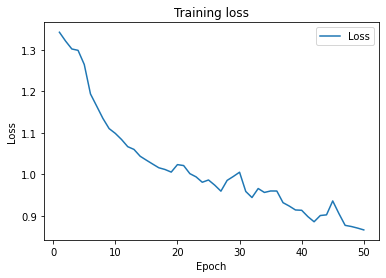

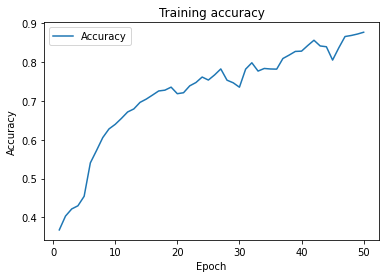

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the csv file using pandas
df = pd.read_csv(f'{output_dir}/{model_name}_loss_acc.csv')

# Tracing the evolution of loss over time
plt.plot(df['epoch'], df['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training loss')
plt.legend()
plt.show()

# Tracing the evolution of accuracy over time
plt.plot(df['epoch'], df['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training accuracy')
plt.legend()
plt.show()

In [45]:
#@title Evaluate the model
!python main.py --evaluate                      \
                --model_name $model_name        \
                --size $size                    \
                --batch_size $batch_size        \
                --output_dir $output_dir

Images: 100% 18/18 [00:03<00:00,  5.20it/s]
Accuracy: 0.7874087591240876


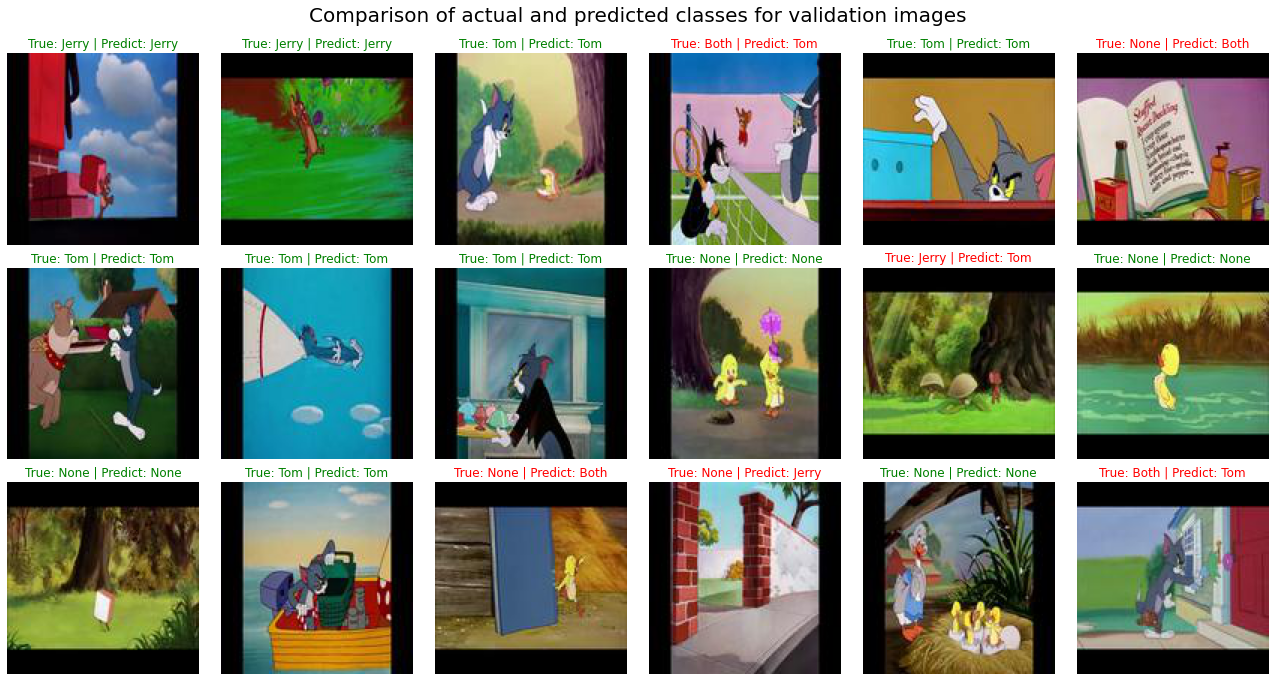

In [46]:
#@title Display results
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

label_name = ['None', 'Jerry', 'Tom', 'Both']

df = pd.read_csv(f'{output_dir}/{model_name}_prediction.csv')
df = df.sample(n=18, random_state=42).reset_index(drop=True)

fig = plt.figure(figsize=(18, 10))

for i, row in df.iterrows():
    if i >= 18: break
    image = Image.open('dataset/imgs/' + row['filename'])
    ax = fig.add_subplot(3, 6, i + 1)
    ax.imshow(image)
    ax.set_title(f"True: {label_name[row['class']]} | Predict: {label_name[row['prediction']]}",
                 color=("green" if row['class'] == row['prediction'] else "red"))
    ax.axis("off")

fig.suptitle("Comparison of actual and predicted classes for validation images", fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()